In [1]:
# dev convenience
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PATHS
import config
import utils
import custom_metrics
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
configs = config.nb_configs

# os.environ["WANDB_SILENT"] = "True"
os.environ["WANDB_NOTEBOOK_NAME"] = "07-model-evaluation.ipynb"

import wandb
print("W&B: ", wandb.__version__)
wandb.login()

PROJECT_NAME = "bagls-sh-test"

W&B:  0.13.5


wandb: Currently logged in as: miked. Use `wandb login --relogin` to force relogin


True

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18096112900111316145
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 14260690529526628772
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15582642997967611379
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10925703168
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation:

2022-12-03 17:15:19.844502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 17:15:22.850035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-12-03 17:15:22.850883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:1 with 10419 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1
2022-12-03 17:15:22.851497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:2 with 10419 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci

## Create bootstraps of the `test` set

In [4]:
# generator
test_datagen = ImageDataGenerator(
    preprocessing_function=None, 
    rescale=configs["rescale"],
)

In [5]:
test_dir = "../test/test"
num_bootstrap = 10 # bootstrap sets
datasets, labels_list, = [], []
df_list = []

for i in range(num_bootstrap):
    # get boostrap dataframes
    csv_path = os.path.join(PATHS.bootstrap_dir, f"test-{i}.csv")
    df = utils.prepare_df(csv_path)
    
    # get labels 1 unhealthy, 0 healthy
    labels_list.append((df["is_healthy"]==False).astype(int))    
    test_dataset = test_datagen.flow_from_dataframe(
        df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=configs["batch_size"],
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
    )
    # log df
    df_list.append(df)
    datasets.append(test_dataset)

Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.
Found 2300 validated image filenames belonging to 2 classes.


## Load Models

In [6]:
# initialize empty values
models = {
    'convnet_from_scratch': None,
    'DenseNet121': None,
    'ResNet50': None,
    'InceptionV3': None, 
    'InceptionResNetV2': None,
}

In [7]:
JOB_TYPE = 'get_model'

for model_name in models:
    run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE, 
                     name=model_name)
    model_at = run.use_artifact("model-" + model_name + ":latest")
    model_dir = model_at.download()
    
    run.finish()
    
    model = keras.models.load_model(model_dir, compile=False)
    # model = keras.models.load_model(
    #     model_dir, custom_objects=metrics_dict, compile=False)
    model.trainable = False
    model.compile()
    model.trainable
    models[model_name] = model

wandb: Downloading large artifact model-convnet_from_scratch:latest, 111.03MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.2


2022-12-03 17:15:44.631638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10419 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-12-03 17:15:44.632707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10419 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1
2022-12-03 17:15:44.633699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10419 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1
2022-12-03 17:15:44.634731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10419 MB memory:  -> device: 3, name: NVIDIA GeForce

wandb:   4 of 4 files downloaded.  


wandb: Downloading large artifact model-ResNet50:latest, 106.03MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.0


wandb: Downloading large artifact model-InceptionV3:latest, 101.47MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


wandb: Downloading large artifact model-InceptionResNetV2:latest, 231.20MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.1


## Evaluate models

### Inspect ROC and PR curves

  0%|          | 0/10 [00:00<?, ?it/s]2022-12-03 17:18:25.748581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-03 17:18:28.967803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400
100%|██████████| 10/10 [02:21<00:00, 14.16s/it]


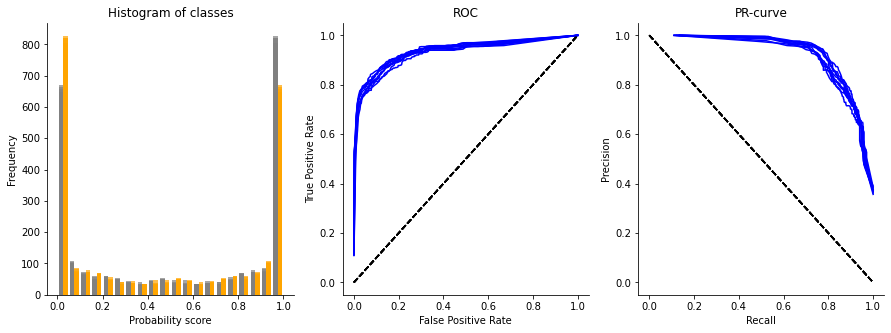

In [8]:
model_name = 'DenseNet121'
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.flatten()

for i in tqdm(range(num_bootstrap)):
    true = labels_list[i]
    preds = models[model_name].predict(datasets[i])
    results = utils.get_results(true, preds, num_thresh=100, class_index=1) # unhealthy
    ax = utils.plot_results(ax, *results)
plt.show()

In [39]:
# log to wandb
run = wandb.init(
    project=PROJECT_NAME, job_type='log_curves', 
    name=f'curves-logging'
)
run.log({f'{model_name}-curves': wandb.Image(fig)})
run.finish()

### Calibration based on ROC and PR

In [10]:
def best_roc_thresh(true, pred_proba, num_thresh):
    fprs, tprs, thresh_arr = utils.get_roc(
        true, pred_proba, num_thresh, return_thresh_arr=True)
    fprs  = np.array(fprs)
    tprs  = np.array(tprs)    
    # maximize product of tpr and 1 - fpr
    best_thresh = thresh_arr[np.argmax((1 - fprs) * tprs)]
    
    print(f"Best ROC thresh: {best_thresh:.4f}")
    return best_thresh
    
def best_pr_thresh(true, pred_proba, num_thresh):
    rs, ps, thresh_arr = utils.get_pr(
        true, pred_proba, num_thresh, return_thresh_arr=True)
    rs  = np.array(rs)
    ps  = np.array(ps)    
    # maximize product of r and p
    best_thresh = thresh_arr[np.argmax(rs*ps)]
    
    print(f"Best PR thresh: {best_thresh:.4f}")
    return best_thresh

In [11]:
class_index = 1 # unhealthy
i = 0 # one bootstrap set
num_thresh = 200
true = labels_list[i]
preds = models[model_name].predict(datasets[i])

# get proba for class of interest : unhealthy
pred_proba = utils.get_class_proba(preds, class_index=class_index)
roc_thresh = best_roc_thresh(true, pred_proba, num_thresh)
pr_thresh = best_pr_thresh(true, pred_proba, num_thresh)

Best ROC thresh: 0.8291
Best PR thresh: 0.8291


### Get Calibrated Results

In [12]:
# read actual test set
csv_path = os.path.join(PATHS.test_meta)
df = utils.prepare_df(csv_path)
test_dataset = test_datagen.flow_from_dataframe(
        df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=configs["batch_size"],
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
    )
class_index = 1 # unhealthy
num_thresh = 200

Found 2300 validated image filenames belonging to 2 classes.


In [13]:
# will be used to log all calibrated results from all models
overall_metrics = {}
results_tables = {}
for name, model in models.items():
    print(f"Currently running {name}")
    true = test_dataset.labels
    preds = model.predict(test_dataset)
    
    # get proba for class of interest : unhealthy
    pred_proba = utils.get_class_proba(preds, class_index=class_index)
    roc_thresh = best_roc_thresh(true, pred_proba, num_thresh)
    temp_df = df.copy()
    temp_df['pred_proba_healthy'] = preds[:, 0]
    temp_df['pred_proba_unhealthy'] = preds[:,1]
    temp_df['prediction'] = temp_df['pred_proba_unhealthy'].apply(
        lambda x: 'unhealthy' if (x > roc_thresh) else 'healthy')
    
    run = wandb.init(
        project=PROJECT_NAME, job_type='log_results', 
        name=f'{name}-inference-results-logging', config=configs
    )
    columns = temp_df.columns.tolist()
    results_table = wandb.Table(columns=columns)
    for index, row in temp_df.iterrows():
        results_table.add_data(*row.tolist())
    
    run.log({f'{name}-results-table': results_table})
    run.finish()
    results_tables[name] = temp_df # dict log
    
    # get model overall metrics
    conf = utils.get_conf(true, pred_proba, thresh=roc_thresh)
    temp_metrics = {
        'calibrated_thresh': roc_thresh,
        'roc-auc': auc(*utils.get_roc(true, pred_proba, num_thresh)),
        'pr-auc': auc(*utils.get_pr(true, pred_proba, num_thresh)),
        'recall': utils.get_sensitivity(*conf),
        'fpr': utils.get_fpr(*conf),
        'specificity': utils.get_specificity(*conf),
        'precision': utils.get_ppv(*conf),
        'npv': utils.get_npv(*conf),
        'f1': utils.get_fbeta(*conf),
        'mcc': utils.get_mcc(*conf),
    }
    overall_metrics[name] = temp_metrics

  0%|          | 0/5 [00:00<?, ?it/s]

Best ROC thresh: 0.9899


 20%|██        | 1/5 [00:36<02:25, 36.38s/it]

Best ROC thresh: 0.8291


 40%|████      | 2/5 [01:13<01:49, 36.57s/it]

Best ROC thresh: 0.2462


 60%|██████    | 3/5 [01:50<01:14, 37.03s/it]

Best ROC thresh: 0.5829


 80%|████████  | 4/5 [02:29<00:37, 37.74s/it]

Best ROC thresh: 0.3417


100%|██████████| 5/5 [03:10<00:00, 38.16s/it]


In [14]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_model-metrics', 
    name=f'overall-metrics-logging'
)
metrics_df = pd.DataFrame.from_dict(
    overall_metrics, orient='index')
metrics_df.index.name = 'Model'
metrics_df = metrics_df.reset_index()

columns = metrics_df.columns.tolist()
metrics_table = wandb.Table(columns=columns)
for index, row in metrics_df.iterrows():
    metrics_table.add_data(*row.tolist())

run.log({f'overall-metrics-table': metrics_table})
run.finish()
display(metrics_df)

,Model,calibrated_thresh,roc-auc,pr-auc,recall,fpr,specificity,precision,npv,f1,mcc
0,convnet_from_scratch,0.989950,0.849312,0.625146,0.643529,0.028276,0.971724,0.930272,0.823014,0.930272,0.680780
1,DenseNet121,0.829146,0.931838,0.795174,0.818824,0.076552,0.923448,0.862454,0.896852,0.862454,0.750740
2,ResNet50,0.246231,0.847348,0.704927,0.832941,0.281379,0.718621,0.634409,0.880068,0.634409,0.532696
3,InceptionV3,0.582915,0.888244,0.831792,0.785882,0.204138,0.795862,0.692946,0.863772,0.692946,0.569094
4,InceptionResNetV2,0.341709,0.892005,0.829710,0.805882,0.171724,0.828276,0.733405,0.879209,0.733405,0.623293


## Best Model Evaluation

Let's inspect the following:
* True positives: Correct predictions of unhealthy glottis
* False negatives: Predicted healthy but are otherwise unhealthy

In [15]:
# read results csv from wandb
run = wandb.init()
artifact = run.use_artifact(
    'miked/bagls-sh-test/run-1sbrgb9e-DenseNet121resultstable:latest', 
    type='run_table')
artifact_dir = artifact.download()

print(artifact_dir)
run.finish()

wandb:   1 of 1 files downloaded.  


./artifacts/run-1sbrgb9e-DenseNet121resultstable:v0


In [16]:
!ls ./artifacts/run-2rqxvxl1-DenseNet121resultstable:v0

DenseNet121-results-table.table.json


In [18]:
import json
from glob import glob

path = glob(os.path.join(artifact_dir, "*.json"))[0]
with open(path, 'r') as file:
    data = json.load(file)
data.keys()

dict_keys(['_type', 'column_types', 'columns', 'data', 'ncols', 'nrows'])

In [19]:
df = pd.DataFrame(data=data['data'], columns=data['columns'])
# get all unhealthy
unhealthy_df = df[df['is_healthy']==0]

In [32]:
case_counts = pd.DataFrame()
fn, tp, index_list = [], [], []

for index in unhealthy_df['Subject disorder status'].unique():
    count_fn = (
        (unhealthy_df['Subject disorder status']==index) & 
        (unhealthy_df['prediction']=='healthy')
    ).sum()
    count_tp = (
        (unhealthy_df['Subject disorder status']==index) & 
        (unhealthy_df['prediction']=='unhealthy')
    ).sum()
    # costmetics: shorten disorder status
    if len(index) > 70:
        index = list(index)
        index.insert(70, "\n")
        index = ''.join(index)
        
    index_list.append(index)
    fn.append(count_fn)
    tp.append(count_tp)
    
case_counts['Disorder']= index_list
case_counts['false-negative (pred-healthy)'] = fn
case_counts['true-positive (pred-unhealthy)'] = tp
case_counts = case_counts.set_index('Disorder')

laryngitis
Muscle tension dysphonia
Vocal fold nodules (high phonation)
Reinke's edema right vocal fold (earlier it was bilateral)
Cyst vocal fold left (posterior insufficient glottic closure) 
Reinke's edema right vocal fold with hourglass-shaped insufficient glo
ttic closure
Polyp
Post-resection of extreme polipoid pendulating edema right vocal folds
; extreme polipoid pendulating edema obstructing almost complete glottis left vocal folds
Lateral-posterior vocal fold cyst (high phonation)
edema
Bilateral vergeture with bowed insufficient glottic closure
scar
Hourglass-shaped insufficient glottic closure (high phonation)
spasmodic dysphonia
paresis


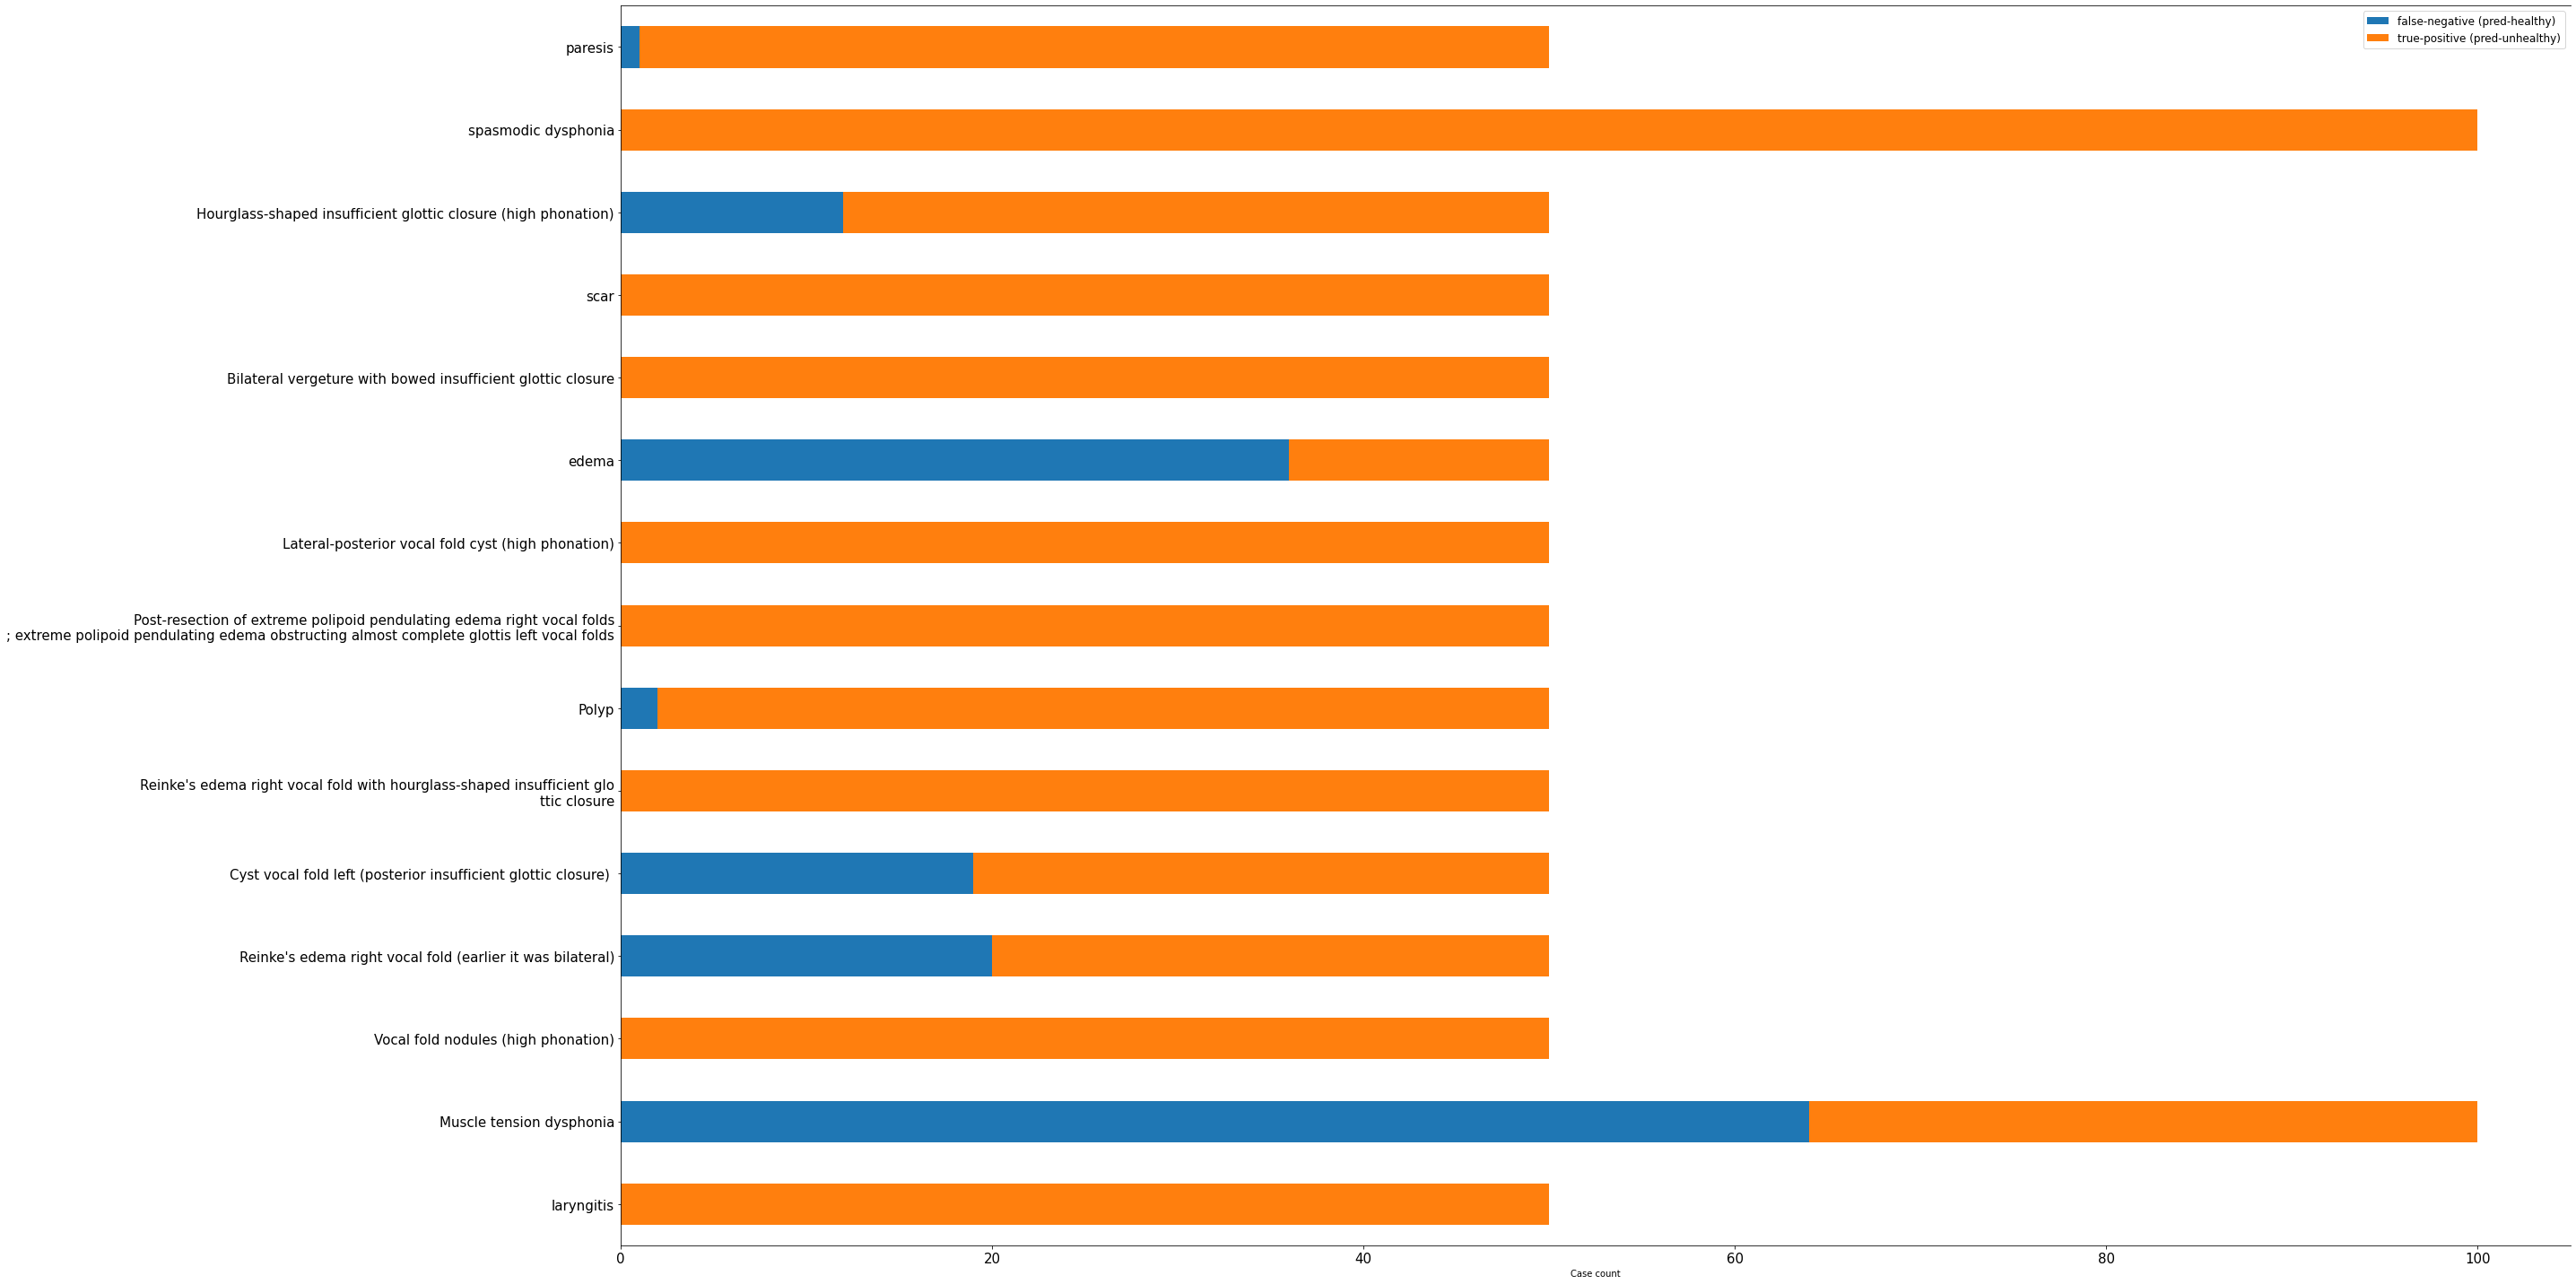

In [111]:
fig, ax = plt.subplots(figsize=(40,20))
case_counts.plot.barh(stacked=True, ax=ax)
ax.spines.right.set_visible(False)
plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=0)
plt.ylabel('')
plt.xlabel('Case count')
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [112]:
# log to wandb
run = wandb.init(
    project=PROJECT_NAME, job_type='log_disorder_eval', 
    name=f'per-disorder-eval'
)
run.log({f'{model_name}-disorder-eval': wandb.Image(fig)})
run.finish()

In [68]:
# focus list
disorders = ['Muscle tension dysphonia', 'edema']
df = df[df['Subject disorder status'].isin(disorders)]

test_dataset = test_datagen.flow_from_dataframe(
        df, directory=test_dir, 
        x_col='filename', y_col='class',
        target_size=configs["image_size"],
        color_mode=configs["cmap"],
        classes=configs["class_names"],
        class_mode=configs["label_mode"],
        batch_size=df.shape[0],    
        interpolation=configs["interpol"],
        validate_filenames=True,
        shuffle=False,
)

Found 150 validated image filenames belonging to 2 classes.


In [94]:
import interpretation
model_name = 'DenseNet121'

# prep data
data, labels = test_dataset[0]

# init gradcam class
layer_name = utils.get_last_conv_layer(models[model_name])
cam = interpretation.GradCAM(models[model_name], layer_name)

images, gradcams = [], []
for image, label_arr in zip(data, labels):
    image = np.expand_dims(image, 0)

    # get gradcam heatmap, use pred_index
    heatmap = cam.compute_heatmap(image)

    # append image: remove batch axis, rescale, and convert to uint8
    image = image.reshape(image.shape[1:])
    image = image * 255
    images.append(tf.keras.preprocessing.image.array_to_img(image))
    image = image.astype(np.uint8)

    # overlay gradcam heatmap results to image
    superimposed_img = cam.overlay_heatmap(heatmap, image)

    # append original and gradcam overlay image
    gradcams.append(superimposed_img)

In [122]:
run = wandb.init(
    project=PROJECT_NAME, job_type='log_gradcam', 
    name=f'gradcam_logger'
)

columns = df.columns.tolist() + ['image', 'gradcam_overlay']
gradcam_table = wandb.Table(columns=columns)

for index, (_, data) in enumerate(df.iterrows()):
    row = data.tolist() + [wandb.Image(image[index])] + [wandb.Image(gradcams[index])]
    gradcam_table.add_data(*row)

run.log({"interpretation" : gradcam_table})
run.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Control-C detected -- Run data was not synced


Thread HandlerThread:
Traceback (most recent call last):
  File "/home/mdorosan/.local/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 50, in run
    self._run()
  File "/home/mdorosan/.local/lib/python3.9/site-packages/wandb/sdk/internal/internal_util.py", line 97, in _run
    record = self._input_record_q.get(timeout=1)
  File "/home/mdorosan/.conda-envs/msds2022-ml3/lib/python3.9/multiprocessing/queues.py", line 117, in get
    res = self._recv_bytes()
  File "/home/mdorosan/.conda-envs/msds2022-ml3/lib/python3.9/multiprocessing/connection.py", line 217, in recv_bytes
    self._check_closed()
  File "/home/mdorosan/.conda-envs/msds2022-ml3/lib/python3.9/multiprocessing/connection.py", line 141, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed


wandb: ERROR Internal wandb error: file data was not synced


Problem at: /tmp/ipykernel_3418/2458556744.py 1 <module>


Traceback (most recent call last):
  File "/home/mdorosan/.local/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 1078, in init
    run = wi.init()
  File "/home/mdorosan/.local/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 697, in init
    result = handle.wait(
  File "/home/mdorosan/.local/lib/python3.9/site-packages/wandb/sdk/lib/mailbox.py", line 259, in wait
    raise MailboxError("transport failed")
wandb.errors.MailboxError: transport failed
wandb: ERROR Abnormal program exit


Exception: problem